<a href="https://colab.research.google.com/github/felladib/CapuchinBirdAudioClassification/blob/main/CapuchinBirdAudioClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install librosa pyaudio tensorflow

# **import dependencies**

In [ ]:
!pip install tensorflow_io  # Install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 16.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Dense , Flatten
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import librosa
import IPython.display as ipd
import os
import matplotlib.pyplot as plt
import warnings
from IPython.display import Audio, display
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files

# **Importation des données depuis KAGGLE**

In [ ]:
# uploaded = files.upload()

In [ ]:
# installer l'API kaggle
!pip install -q kaggle

In [ ]:
# créer le dossier .kaggle et y deplacer kaggel.json pour l'authentification
!mkdir -p ~/.kaggle

In [ ]:
# Cette commande déplace votre fichier kaggle.json, qui contient vos informations d'identification API Kaggle, dans le répertoire ~/.kaggle/ que vous venez de créer. Cela permet à l'environnement Kaggle de trouver vos informations d'identification lors de l'utilisation de l'API Kaggle.
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
# Cette commande modifie les autorisations du fichier kaggle.json pour qu'il soit accessible en lecture et écriture uniquement par l'utilisateur propriétaire du fichier. Cela garantit que vos informations d'identification API Kaggle sont protégées contre les accès non autorisés.
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# telecharger le jeu de données
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

Dataset URL: https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing
License(s): CC-BY-NC-SA-4.0
100% 602M/604M [00:07<00:00, 59.7MB/s]
100% 604M/604M [00:07<00:00, 89.6MB/s]


In [ ]:
# Extraire le contenu du fichier zip
!unzip -q z-by-hp-unlocked-challenge-3-signal-processing.zip -d data

In [ ]:
# Lister les fichiers dans le répertoire cv-valid-train
audio_files = os.listdir('/content/data')
print(len(audio_files))  # Afficher les 10 premiers fichiers pour vérification

3


In [ ]:
# import shutil

# # Supprimer le répertoire et tout son contenu
# shutil.rmtree('/content/data')

# # Vérifier si le répertoire a été supprimé
# import os
# print(os.path.exists('/content/data'))  # Cela devrait retourner False

# **Traitement Audio**

In [ ]:
# charger le fichier csv des données d'entrainement
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename) # Elle lit le fichier en tant que chaîne d'octets encodée.
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) #wav : Contient les données audio en tant que tenseur.sample_rate : Contient la fréquence d'échantillonnage originale du fichier audio.
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1) #Cette fonction supprime une dimension inutile du tenseur wav. Les fichiers audio peuvent avoir un axe supplémentaire de longueur 1, et cette ligne le supprime pour simplifier les opérations ultérieures
    sample_rate = tf.cast(sample_rate, dtype=tf.int64) #: Convertit la fréquence d'échantillonnage en un entier de type int64. Cela peut être nécessaire pour certaines opérations qui exigent un type de données spécifique.
    # Goes from 44100HZ to 16000HZ -amplitude of the audio signla
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) #Cette fonction utilise TensorFlow I/O pour rééchantillonner les données audio. Elle change la fréquence d'échantillonnage de sample_rate (qui peut être 44.1 kHz, 48 kHz, etc.) à 16 kHz, une fréquence plus courante pour des tâches comme la reconnaissance vocale ou le traitement du signal.
    return wav

In [ ]:
wav_capuchin = load_wav_16k_mono('/content/data/Parsed_Capuchinbird_Clips/XC114131-0.wav')

In [ ]:
wav_Not_capuchin = load_wav_16k_mono('/content/data/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav')

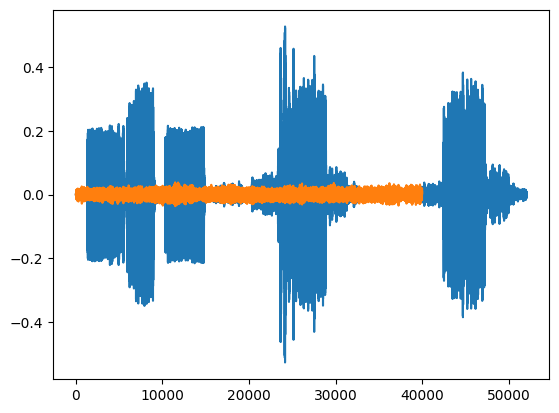

In [ ]:
plt.plot(wav_Not_capuchin)
plt.plot(wav_capuchin)
plt.show()

In [ ]:
# Écouter le fichier Capuchinbird
print("Playing Capuchinbird Audio:")
display(Audio(wav_capuchin.numpy(), rate=16000))

Playing Capuchinbird Audio:


In [ ]:
# Écouter le fichier Not Capuchinbird (Crickets)
print("Playing Not Capuchinbird Audio (Crickets):")
display(Audio(wav_Not_capuchin.numpy(), rate=16000))

Playing Not Capuchinbird Audio (Crickets):


# **Transforamtion spectral**
Un spectrogramme est une représentation visuelle de l'intensité des fréquences sonores dans un signal au fil du temps.

* define two paths to Positive and negative data

In [ ]:
# import glob

# glob permet de rechercher des fichiers en utilisant des motifs (patterns). Ici, on recherche tous les fichiers avec l'extension .wav dans le répertoire spécifié.
# def list_wav_files(directory):
      #Utilise glob pour trouver tous les fichiers .wav dans le répertoire spécifié
#     return glob.glob(os.path.join(directory, '*.wav'))


# os.listdir(directory) : Cette fonction retourne une liste de tous les fichiers et dossiers dans le répertoire spécifié par directory.f.endswith('.wav') : Cette condition filtre la liste pour ne garder que les fichiers qui se terminent par .wav, c'est-à-dire les fichiers audio au format WAV.
# def list_wav_files(directory):
#     # Liste tous les fichiers dans le répertoire spécifié
#     return [f for f in os.listdir(directory) if f.endswith('.wav')]

In [ ]:
# Chemins des répertoires (utiliser des barres obliques pour la compatibilité multiplateforme)
POS = '/content/data/Parsed_Capuchinbird_Clips'
NEG = '/content/data/Parsed_Not_Capuchinbird_Clips'

In [ ]:
# Créer les datasets(List of chemin)
pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')


In [ ]:
# Afficher le premier chemin de fichier de chaque dataset
print("Premier fichier Capuchinbird :")
print(next(pos.as_numpy_iterator()))

Premier fichier Capuchinbird :
b'/content/data/Parsed_Capuchinbird_Clips/XC526106-4.wav'


In [ ]:
print("Premier fichier Not Capuchinbird :")
print(next(neg.as_numpy_iterator()))

Premier fichier Not Capuchinbird :
b'/content/data/Parsed_Not_Capuchinbird_Clips/crickets-chirping-crickets-sound-20.wav'


* Add label and Combine Postive and Negative Samples

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
next(data.as_numpy_iterator())

(b'/content/data/Parsed_Capuchinbird_Clips/XC216012-10.wav', 1.0)

In [ ]:
# Fonction de prétraitement
def preprocess(file_path, label):
    # Charge et rééchantillonne l'audio
    wav = load_wav_16k_mono(file_path)
    # Tronque ou complète l'audio à 3 secondes
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    # Calcule le spectrogramme via STFT (transformée de Fourier à court terme)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    # Ajuste la forme pour l'input du modèle
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
# del label_test

In [ ]:
file_path , label = data.shuffle(buffer_size=1000).as_numpy_iterator().next()

In [ ]:
file_path , label

(b'/content/data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-22.wav',
 0.0)

In [ ]:
spectrogram , label = preprocess(file_path , label)

In [ ]:
spectrogram , label

(<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
 array([[[7.8814225e-03],
         [9.4049545e-03],
         [7.8068012e-03],
         ...,
         [1.1916954e-05],
         [8.0273931e-06],
         [6.6207722e-06]],
 
        [[1.0309783e-02],
         [8.1222067e-03],
         [3.6352482e-03],
         ...,
         [4.5079896e-06],
         [4.9123596e-06],
         [2.8898939e-06]],
 
        [[8.8175870e-03],
         [6.9539514e-03],
         [3.3487568e-03],
         ...,
         [1.4579596e-06],
         [1.3279281e-06],
         [3.3387914e-07]],
 
        ...,
 
        [[1.7330931e-03],
         [1.3499269e-03],
         [6.0612720e-04],
         ...,
         [1.1011176e-06],
         [1.4113806e-06],
         [1.5697442e-06]],
 
        [[1.8425966e-03],
         [1.4260310e-03],
         [6.0873025e-04],
         ...,
         [2.6657492e-06],
         [2.4168396e-06],
         [2.3851171e-06]],
 
        [[1.9015223e-03],
         [1.4975043e-03],
         [6

In [ ]:
spectrogram.shape

TensorShape([1491, 257, 1])

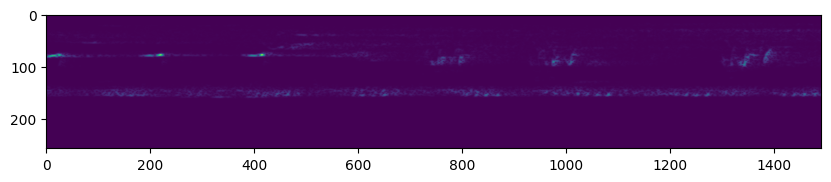

In [ ]:
plt.figure(figsize = (10,8))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
len(data)

810

# **creating Training and Testing partitions**

* Create a tensorflow Data pipeline

Un pipeline est une séquence organisée de transformations ou de processus appliqués aux données pour les préparer à un objectif final. Que ce soit pour l'ingénierie des données, l'apprentissage automatique, ou d'autres domaines, les pipelines permettent d'automatiser et de rationaliser le traitement des données, assurant ainsi une gestion efficace et cohérente des données tout au long du processus.

In [ ]:
# Applique la fonction preprocess à chaque élément du jeu de données data. Cette fonction convertit les fichiers audio en spectrogrammes et associe chaque spectrogramme à une étiquette.
data  = data.map(preprocess)

In [ ]:
import pandas as pd

# Convertir les données en une liste de tuples
data_list = list(data.as_numpy_iterator())

# Séparer les données et les labels
x_data = [x for x, y in data_list]
y_data = [y for x, y in data_list]

# Convertir en DataFrame
x_df = pd.DataFrame([x.flatten() for x in x_data])  # Flatten pour obtenir des vecteurs
y_df = pd.DataFrame(y_data, columns=['label'])

# Afficher les DataFrames
print(x_df.head())
print(y_df.head())


In [ ]:
# Applique la fonction preprocess à chaque élément du jeu de données data. Cette fonction convertit les fichiers audio en spectrogrammes et associe chaque spectrogramme à une étiquette.
data  = data.map(preprocess)
#  est une méthode utilisée pour stocker en mémoire les données du pipeline après le premier passage. Cela signifie que les données sont chargées et prétraitées une fois, puis stockées en mémoire pour des accès ultérieurs plus rapides.
data = data.cache()
# Mélange les données avec un tampon de 1000 éléments pour introduire de l'aléatoire dans l'ordre des échantillons, ce qui aide à réduire le biais durant l'entraînement.
data = data.shuffle(buffer_size=1000)
# Regroupe les échantillons en lots (batches) de 16 échantillons pour que le modèle puisse les traiter ensemble, ce qui est plus efficace que de traiter chaque échantillon individuellement.
data = data.batch(16)
# Précharge 8 lots (batches) dans la mémoire pendant que le modèle traite le lot actuel. Cela améliore la performance globale en réduisant les temps d'attente entre le traitement des lots.
data = data.prefetch(8)

* Split into Training and Testing Partitions

In [ ]:
len(data)

51

In [ ]:
next(data.as_numpy_iterator())

(array([[[[1.44324750e-02],
          [1.06663993e-02],
          [4.83847549e-03],
          ...,
          [8.43460930e-06],
          [2.22798608e-05],
          [1.12433918e-05]],
 
         [[1.61472335e-02],
          [9.29283258e-03],
          [4.72966162e-03],
          ...,
          [1.22848487e-05],
          [1.86681627e-05],
          [3.32407653e-05]],
 
         [[1.75476316e-02],
          [1.48477023e-02],
          [9.14569851e-03],
          ...,
          [2.06511722e-05],
          [3.17793310e-05],
          [2.54493207e-05]],
 
         ...,
 
         [[2.16522980e-02],
          [2.06275526e-02],
          [1.51401032e-02],
          ...,
          [4.83535187e-05],
          [9.53600284e-06],
          [1.70674175e-05]],
 
         [[1.31993573e-02],
          [1.70147512e-02],
          [1.93534121e-02],
          ...,
          [3.88492917e-05],
          [5.33011844e-05],
          [1.94367021e-05]],
 
         [[6.22990308e-03],
          [1.10666743e-02]

In [ ]:
# Prend les 36 premiers lots du jeu de données comme données d'entraînement. Cela suppose que le jeu de données a été divisé en un nombre de lots suffisant pour permettre cette séparation.
train = data.take(36)
# Ignore les 36 premiers lots et prend les 15 lots suivants comme données de test. Cela permet de garder une partie des données séparées pour évaluer le modèle.
test = data.skip(36).take(15)

In [ ]:
def verify_spectrogram_lengths(dataset):
    for i, (spectrogram_batch, label_batch) in enumerate(dataset):
        # Vérifie que chaque batch a la forme (batch_size, 1491, 257, 1)
        if spectrogram_batch.shape[:] != (16,1491, 257, 1):  # Exclut la taille du batch
            print(f"Batch {i} has unexpected spectrogram shape: {spectrogram_batch.shape}")

# Appliquer la vérification à votre dataset (par exemple 'train' ou 'test')
verify_spectrogram_lengths(train)


# **Build Deep Learning Model**

* Sequantial model

In [ ]:
for spectrogram_batch, label_batch in train.take(1):
    print("Spectrogram batch shape:", spectrogram_batch.shape)
    print("Label batch shape:", label_batch.shape)

Spectrogram batch shape: (16, 1491, 257, 1)
Label batch shape: (16,)


In [ ]:
# model = Sequential()
# model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
# model.add(Conv2D(16, (3,3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1491, 257, 1)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(129, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


# **Fit Model , View Loss and KPI Plots**

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'] , 'r')
plt.plot(hist.history['val_loss'] , 'r')
plt.show

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'] , 'r')
plt.plot(hist.history['val_precision'] , 'r')
plt.show


# **Model with class**

In [ ]:
class AudioClassifier(tf.keras.Model):

  def __init__(self , cnn_size):
    super(AudioClassifier , self).__init__()
    print('hello world ')
    self.cnn1 = Conv2D(cnn_size ,kernel_size=(3, 3), activation='relu',input_shape=(1491, 257, 1)) # Initialize layers as instance attributes
    self.cnn2 = Conv2D(cnn_size ,kernel_size=(3, 3), activation='relu')
    self.flatten = Flatten()
    self.dense1 = Dense(129, activation='relu')
    self.dense2 = Dense(1 , activation ='sigmoid')

  def call(self, input):
    print("Input shape:", tf.shape(input))
    x = self.cnn1(input)
    print("After cnn1 shape:", tf.shape(x))
    x = self.cnn2(x)
    print("After cnn2 shape:", tf.shape(x))
    x = self.flatten(x)
    print("After flatten shape:", tf.shape(x))
    x = self.dense1(x)
    print("After dense1 shape:", tf.shape(x))
    return self.dense2(x)


In [ ]:
model = AudioClassifier(16)

hello world 


In [ ]:
# model.summary()

In [ ]:
model.compile(optimizer='Adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
for spectrogram_batch, label_batch in train.take(1):
    print("Spectrogram batch shape:", spectrogram_batch.shape)
    print("Label batch shape:", label_batch.shape)

Spectrogram batch shape: (16, 1491, 257, 1)
Label batch shape: (16,)


In [ ]:
history = model.fit(train ,
                    epochs = 4 ,
                    validation_data = test)

In [ ]:
model.evaluate(test)

In [ ]:
model.predict(next(test.as_numpy_iterator()))